<a href="https://colab.research.google.com/github/pmaishev/dls2023/blob/main/%5Bhomework_2023_2_pm%5Ddense_and_convolutional_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)


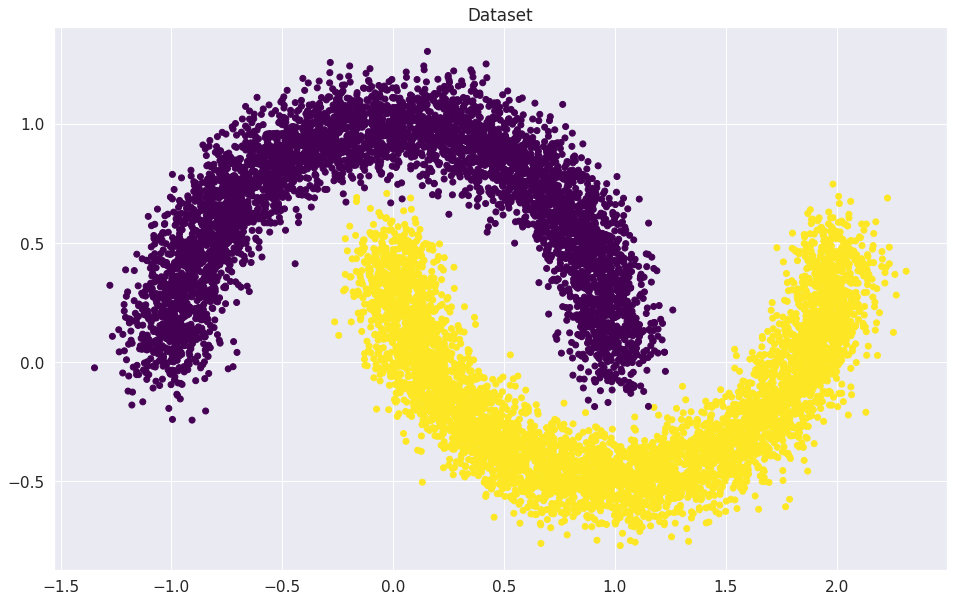

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
# Используем функцию torch.from_numpy
X_train_t =  torch.from_numpy(X_train)
y_train_t =  torch.from_numpy(y_train)
X_val_t =  torch.from_numpy(X_val)
y_val_t =  torch.from_numpy(y_val)


Создаем `Dataset` и `DataLoader`. 

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad=True).type(torch.float32))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1).type(torch.float32), requires_grad=True) # YOUR CODE GOES HERE

    def forward(self, x):
        x = torch.mm(x.type(torch.float32), self.weights) # Умножаем входной тензор на тензор весов
        if self.bias:
            x +=  self.bias_term # Добавляем смещение
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [ ]:
import math
res = 0
for p in list(linear_regression.parameters()):
  res += math.prod(list(p.shape))
print(f"Всего в модели {res} числовых переменных")

Всего в модели 3 числовых переменных


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(torch.flatten(outp), y_batch.type(torch.float32)) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.6171875
Iteration: 100
Batch accuracy: 0.8828125
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.8984375
Iteration: 500
Batch accuracy: 0.9140625

Iteration: 578.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 578

### Визуализируем результаты

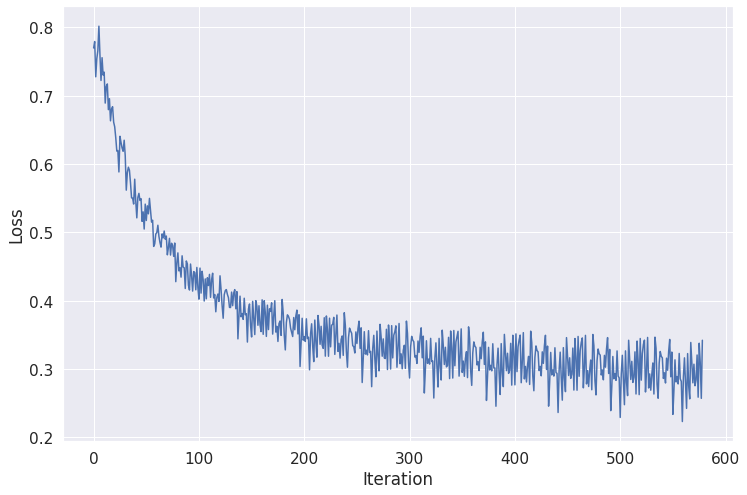

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

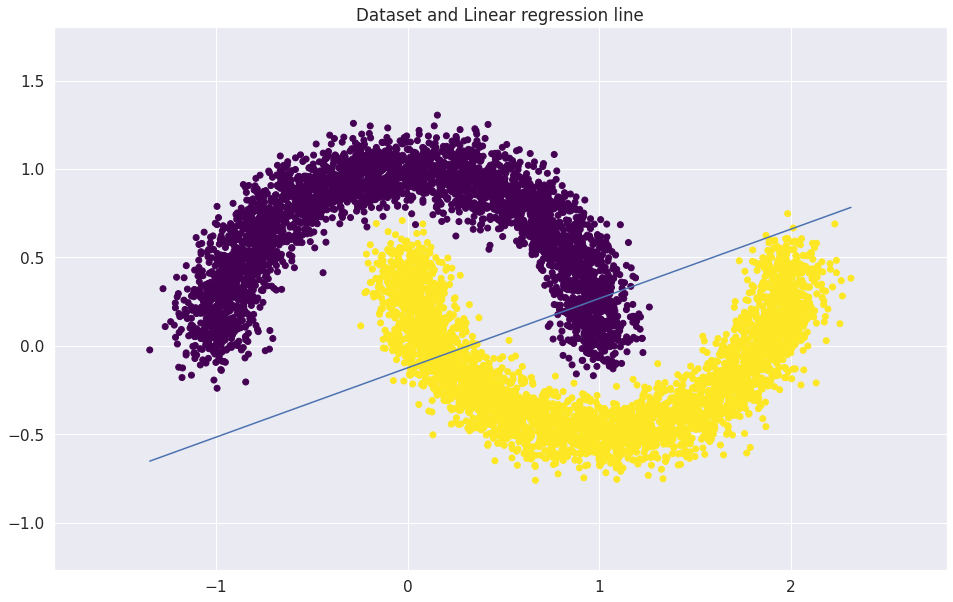

In [ ]:
w = linear_regression.weights.detach().clone()
b = linear_regression.bias_term.detach().clone()
plt.figure(figsize=(16, 10))
plt.title("Dataset and Linear regression line")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="viridis")
u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
plt.plot(u, (0.5-b-w[0]*u)/w[1])
plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)

plt.show()

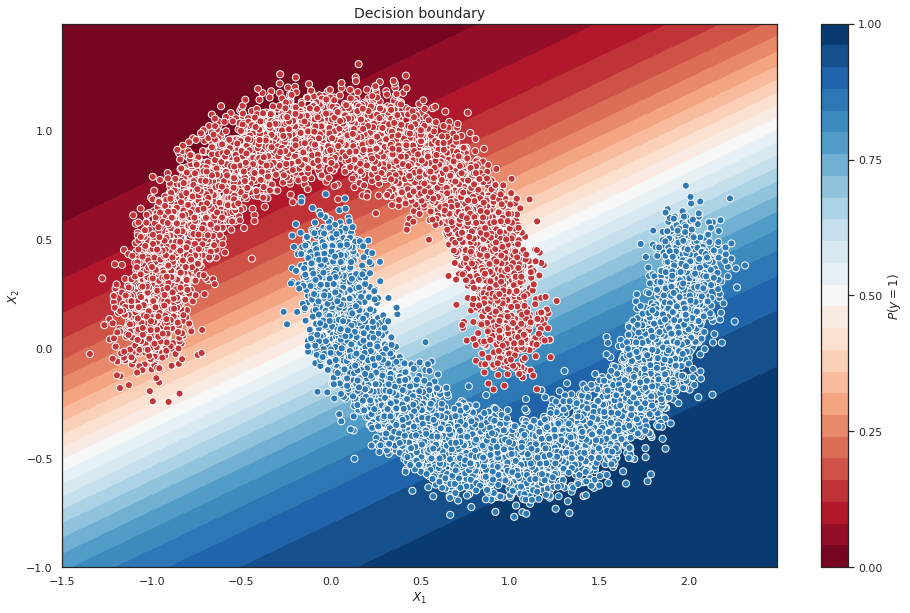

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        #<YOUR CODE>
        outp = model(x_batch)
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long) #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val_t, predict(val_dataloader, linear_regression))

0.876

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.876

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2) # YOUR CODE GOES HERE
valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
activation = nn.ELU
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
D_in, H, D_out = 784, 128, 10

model = nn.Sequential(
    nn.Flatten(),
    #YOUR CODE. Add layers to your sequential class
    nn.Linear(D_in, H),
    activation(),
    nn.Linear(H, H),
    activation(),
    nn.Linear(H, D_out)
)

In [ ]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
model.to(device) # Move model to device (CPU or GPU)
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.view(x_batch.shape[0], -1).to(device) #
            y_batch = y_batch.to(device)
            if k == "train":
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            #TODO: Check everything again
            correct = sum(preds == y_batch).item() # YOUR CODE GOES HERE
            all =  preds.shape[0] # YOUR CODE GOES HERE
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9085666666666666
Loader: valid. Accuracy: 0.938
Epoch: 2
Loader: train. Accuracy: 0.94625
Loader: valid. Accuracy: 0.9544
Epoch: 3
Loader: train. Accuracy: 0.9565333333333333
Loader: valid. Accuracy: 0.9605
Epoch: 4
Loader: train. Accuracy: 0.96025
Loader: valid. Accuracy: 0.9501
Epoch: 5
Loader: train. Accuracy: 0.9626
Loader: valid. Accuracy: 0.9594
Epoch: 6
Loader: train. Accuracy: 0.9648
Loader: valid. Accuracy: 0.9613
Epoch: 7
Loader: train. Accuracy: 0.9673
Loader: valid. Accuracy: 0.9556
Epoch: 8
Loader: train. Accuracy: 0.9682333333333333
Loader: valid. Accuracy: 0.9662
Epoch: 9
Loader: train. Accuracy: 0.9698
Loader: valid. Accuracy: 0.9603
Epoch: 10
Loader: train. Accuracy: 0.9706
Loader: valid. Accuracy: 0.9666


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
def model_fitting(model, loaders):
    criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device) # Move model to device (CPU or GPU)
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                #TODO: Check everything again
                correct = sum(preds == y_batch).item() # YOUR CODE GOES HERE
                all =  preds.shape[0] # YOUR CODE GOES HERE
                epoch_correct += correct
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all:.4f}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

def test_activation_function(activation, loaders):
    print(f"--------------------- {activation.__name__} ---------------------")
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(D_in, H),
        activation(),
        nn.Linear(H, H),
        activation(),
        nn.Linear(H, D_out)
    )
    return model_fitting(model, loaders)

In [ ]:
accuracy_calss_list = [Identical, nn.ReLU, nn.LeakyReLU]
accuracy_results = {"ELU": accuracy}
for accuracy_class in accuracy_calss_list:
    accuracy_results[accuracy_class.__name__] = test_activation_function(accuracy_class, loaders)

# Это для графика из исходного ноутбука. 
elu_accuracy = accuracy_results["ELU"]["valid"]
plain_accuracy = accuracy_results["Identical"]["valid"]
relu_accuracy = accuracy_results["ReLU"]["valid"]
leaky_relu_accuracy = accuracy_results["LeakyReLU"]["valid"]

--------------------- Identical ---------------------
Epoch: 1
Loader: train. Accuracy: 0.8491
Loader: valid. Accuracy: 0.8841
Epoch: 2
Loader: train. Accuracy: 0.8814
Loader: valid. Accuracy: 0.8974
Epoch: 3
Loader: train. Accuracy: 0.8898
Loader: valid. Accuracy: 0.9039
Epoch: 4
Loader: train. Accuracy: 0.8945
Loader: valid. Accuracy: 0.8894
Epoch: 5
Loader: train. Accuracy: 0.8969
Loader: valid. Accuracy: 0.8973
Epoch: 6
Loader: train. Accuracy: 0.8986
Loader: valid. Accuracy: 0.9110
Epoch: 7
Loader: train. Accuracy: 0.8994
Loader: valid. Accuracy: 0.8855
Epoch: 8
Loader: train. Accuracy: 0.8998
Loader: valid. Accuracy: 0.8823
Epoch: 9
Loader: train. Accuracy: 0.9013
Loader: valid. Accuracy: 0.9062
Epoch: 10
Loader: train. Accuracy: 0.9012
Loader: valid. Accuracy: 0.8975
--------------------- ReLU ---------------------
Epoch: 1
Loader: train. Accuracy: 0.9010
Loader: valid. Accuracy: 0.9423
Epoch: 2
Loader: train. Accuracy: 0.9431
Loader: valid. Accuracy: 0.9485
Epoch: 3
Loader: tra

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

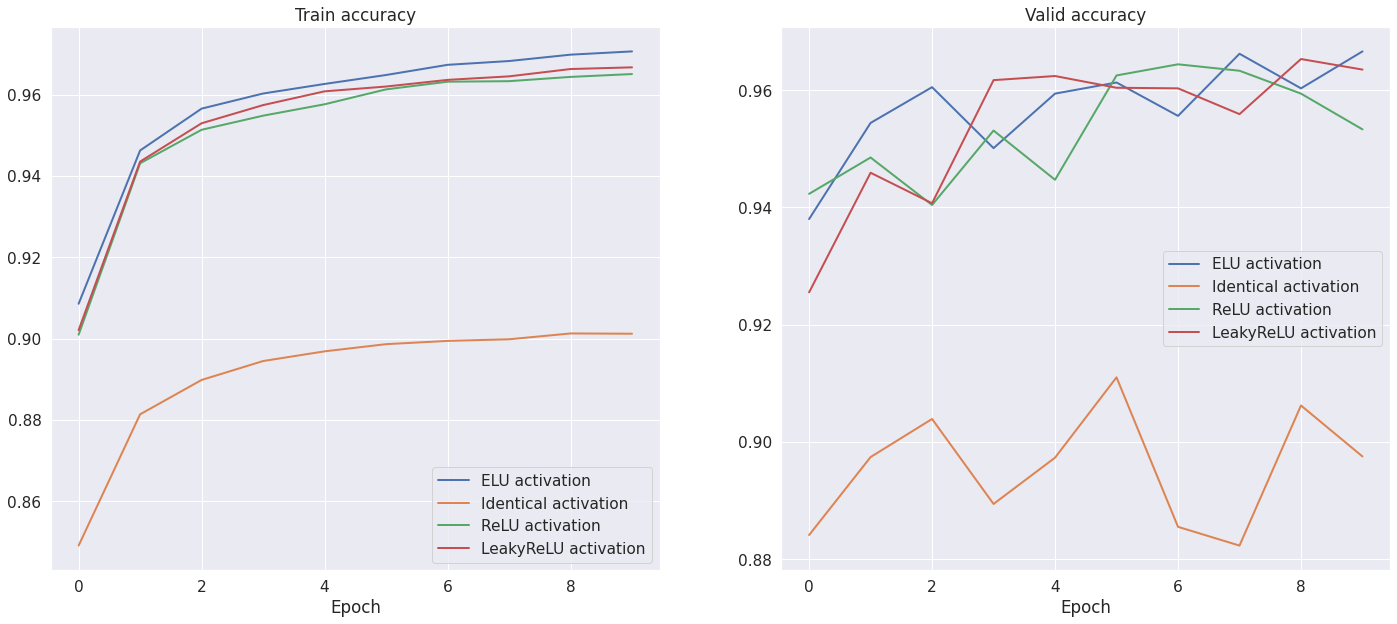

In [ ]:
# График для сравнения тренировочной и валидационной выборки. Ячейка из исходного ноутбука - ниже.
sns.set(style="darkgrid", font_scale=1.4)

fig, axs = plt.subplots(1, 2, figsize=(24, 10))
i = 0
for key in ["train", "valid"]:
    axs[i].set_title(f"{key.capitalize()} accuracy")
    for acc_key in accuracy_results:
        axs[i].plot(range(max_epochs), accuracy_results[acc_key][key], label=f"{acc_key} activation", linewidth=2)
    axs[i].legend()
    axs[i].set_xlabel("Epoch")
    i += 1
plt.show()

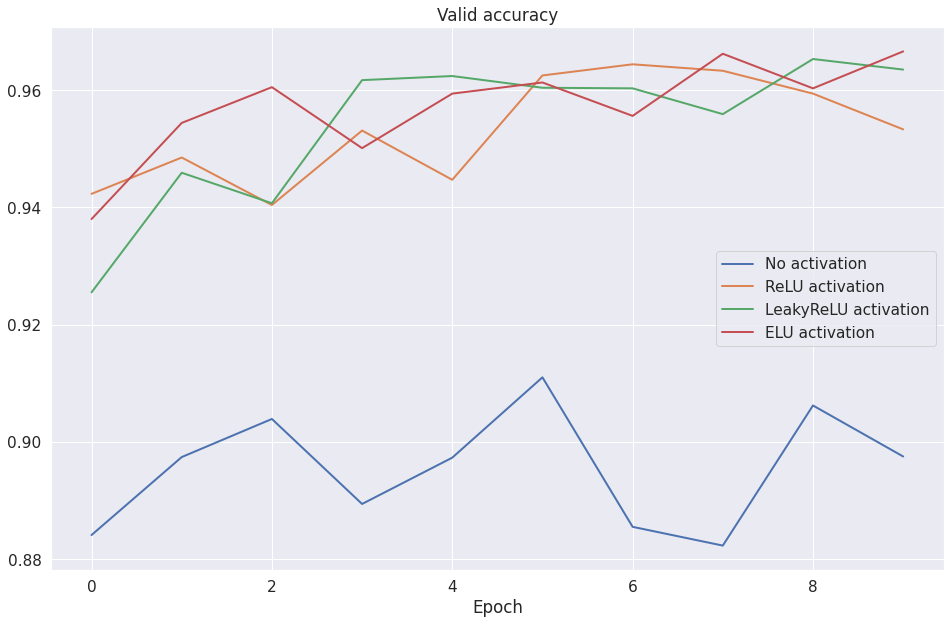

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** Лучший результат показала `ELU` активация. Не сильно отстали `ReLU` и `LeakyReLU`. Хуже всего без активации.

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-03-24 22:35:06--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-03-24 22:35:06--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 172.67.128.246, 104.21.1.92, 2606:4700:3036::ac43:80f6, ...
Connecting to img.the-village-kz.com (img.the-village-kz.com)|172.67.128.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.008s  

2023-03-24 22:35:07

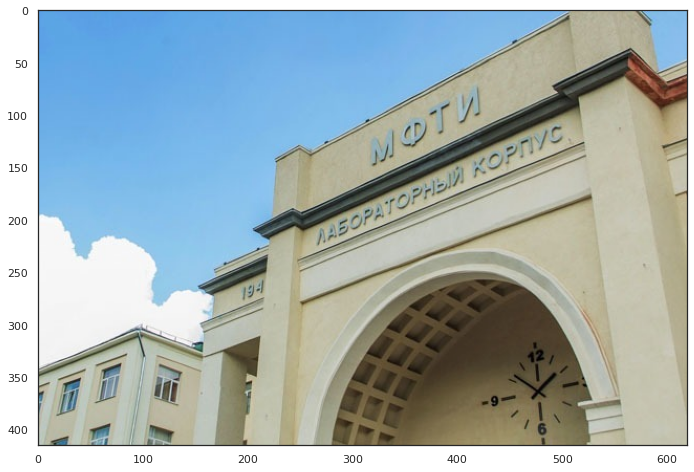

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:

kernels = {
    "A": [[0, 0, 0],[0, 1, 0],[0, 0, 0]],
    "Б": [[0, 1, 0],[0, -2, 0],[0, 1, 0]],
    "В": [[0, 0, 0],[1, -2, 1],[0, 0, 0]],
    "Г": [[0, 1, 0],[1, -4, 1],[0, 1, 0]],
    "Д": [[0, -1, 0],[-1, 5, -1],[0, -1, 0]],
    "Е": [[0.0625, 0.125, 0.0625],[0.125, 0.25, 0.125],[0.0625, 0.125, 0.0625]]
}
    
results = {}
for key in kernels.keys():
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = torch.tensor(kernels[key]).reshape(1, 1, 3, 3).type(torch.float32)

    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]  #
    results[key] = result

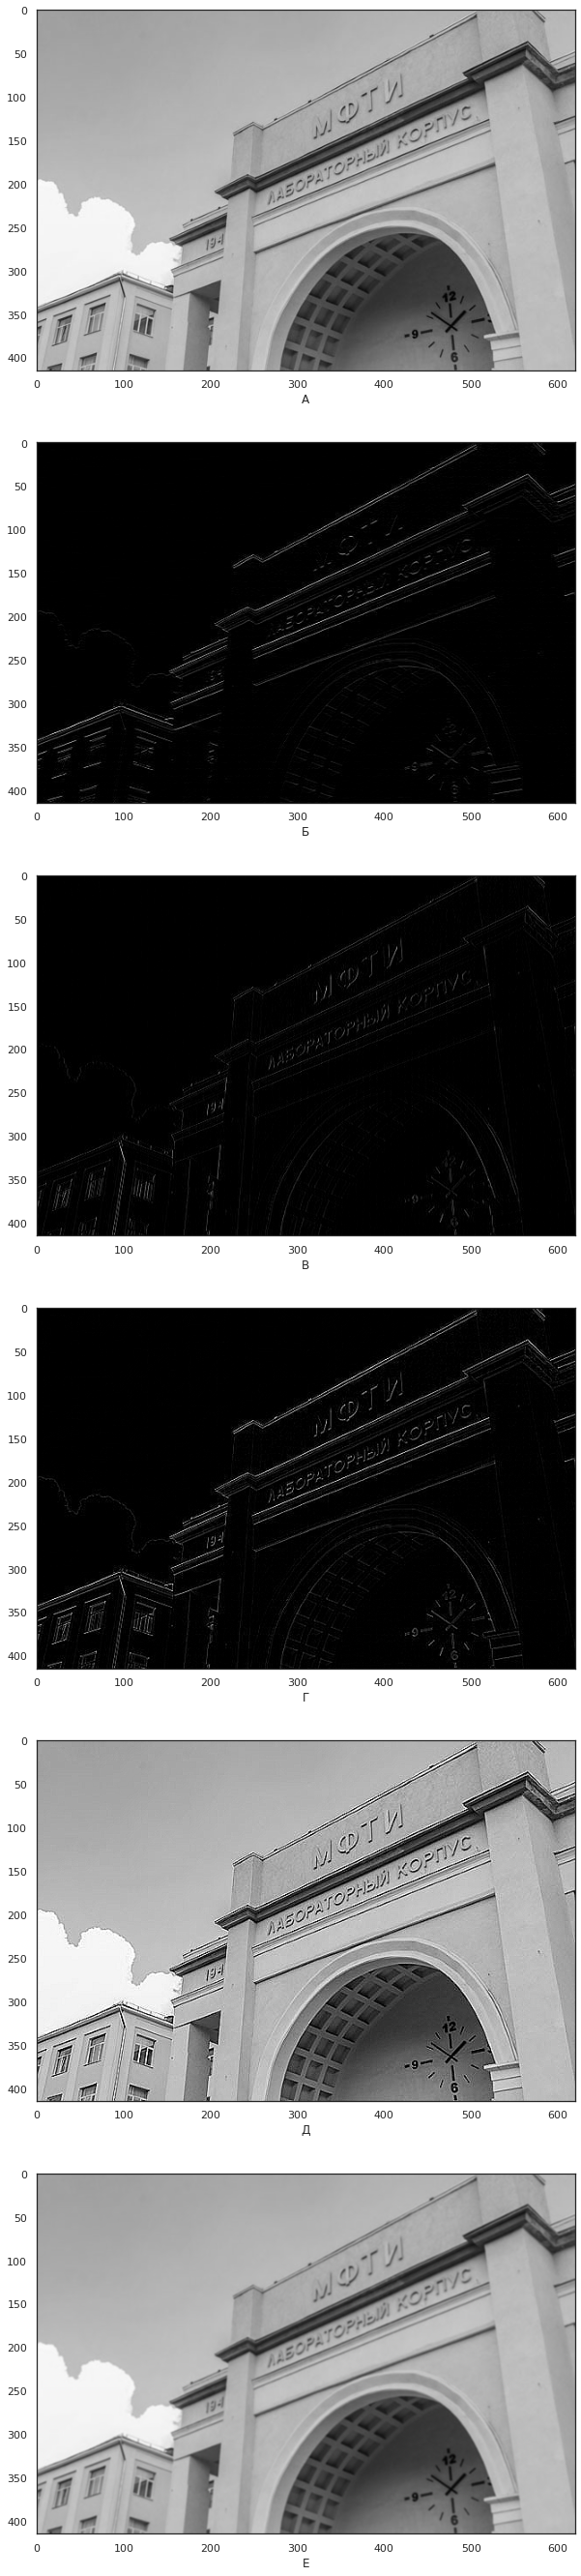

In [ ]:
fig, axs = plt.subplots(len(results), 1, figsize=(12, 8*len(results)))

#plt.figure(figsize=(12, 8))
idx = 0
for key in kernels.keys():
    result_np = results[key].permute(1, 2, 0).numpy() / 256 / 3

    axs[idx].imshow(result_np)
    axs[idx].set_xlabel(key)
    idx += 1

plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 1-Е, 2-Д, 3-А, 4-В, 5-Б, 6-Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(400, 120) #YOUR CODE 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84) #YOUR CODE
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10) #YOUR CODE

    def forward(self, x):
        x = self.conv1(x) #YOUR CODE. Apply layers created in __init__. 
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.fl(x)
        #print(x.shape)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet() #.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
accuracy = model_fitting(model, loaders)

Epoch: 1
Loader: train. Accuracy: 0.9528
Loader: valid. Accuracy: 0.9795
Epoch: 2
Loader: train. Accuracy: 0.9808
Loader: valid. Accuracy: 0.9850
Epoch: 3
Loader: train. Accuracy: 0.9850
Loader: valid. Accuracy: 0.9815
Epoch: 4
Loader: train. Accuracy: 0.9870
Loader: valid. Accuracy: 0.9748
Epoch: 5
Loader: train. Accuracy: 0.9889
Loader: valid. Accuracy: 0.9860
Epoch: 6
Loader: train. Accuracy: 0.9895
Loader: valid. Accuracy: 0.9841
Epoch: 7
Loader: train. Accuracy: 0.9908
Loader: valid. Accuracy: 0.9864
Epoch: 8
Loader: train. Accuracy: 0.9906
Loader: valid. Accuracy: 0.9871
Epoch: 9
Loader: train. Accuracy: 0.9915
Loader: valid. Accuracy: 0.9851
Epoch: 10
Loader: train. Accuracy: 0.9929
Loader: valid. Accuracy: 0.9851


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

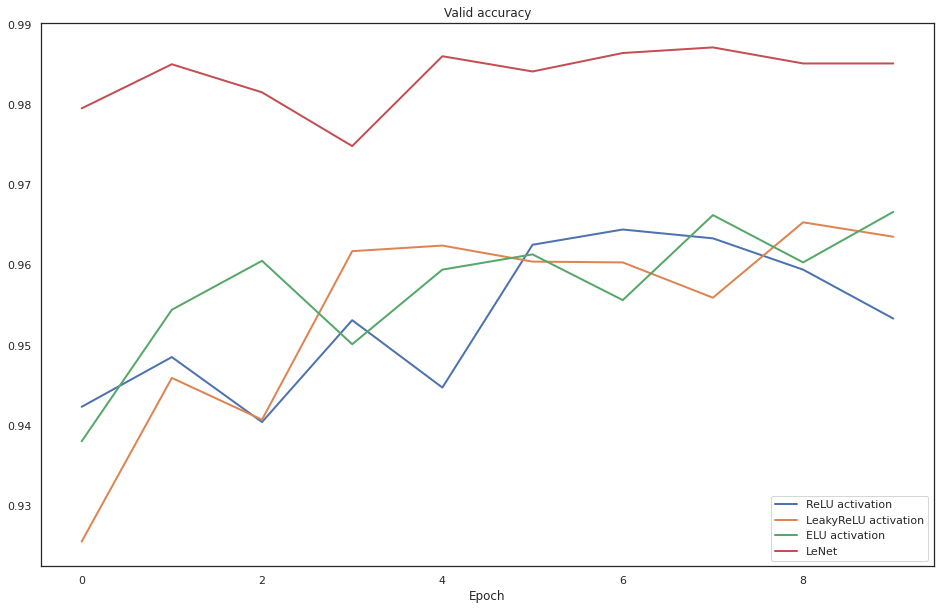

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99